In [1]:
import pandas as pd 
import scanpy as sc

import os 

In [2]:
# Scanpy config
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


# Getting data

3k PBMC data: 
- https://www.akadeum.com/blog/what-is-pbmc-human-pbmc-cells-pbmc-composition-and-immune-cell-processing/
- peripheral blood mononuclear cell
- a variety of specialized immune cells that work together to protect our bodies from harmful pathogens
- PBMCs are typically collected by isolation from whole blood samples

In [3]:
data_path = '../scanpy-tutorials/data/'

In [4]:
adata = sc.read_10x_mtx(
    os.path.join(data_path, 'filtered_gene_bc_matrices/hg19/'),  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/..-scanpy-tutorials-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [8]:
help(adata.var_names_make_unique)

Help on method var_names_make_unique in module anndata._core.anndata:

var_names_make_unique(join: str = '-') method of anndata._core.anndata.AnnData instance
    Makes the index unique by appending a number string to each duplicate index element:
    '1', '2', etc.
    
    If a tentative name created by the algorithm already exists in the index, it tries
    the next integer in the sequence.
    
    The first occurrence of a non-unique value is ignored.
    
    Parameters
    ----------
    join
         The connecting string between name and integer.
    
    Examples
    --------
    >>> from anndata import AnnData
    >>> adata = AnnData(np.ones((2, 3)), var=pd.DataFrame(index=["a", "a", "b"]))
    >>> adata.var_names
    Index(['a', 'a', 'b'], dtype='object')
    >>> adata.var_names_make_unique()
    >>> adata.var_names
    Index(['a', 'a-1', 'b'], dtype='object')



In [9]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## pre-processing 

normalizing counts per cell
    finished (0:00:00)


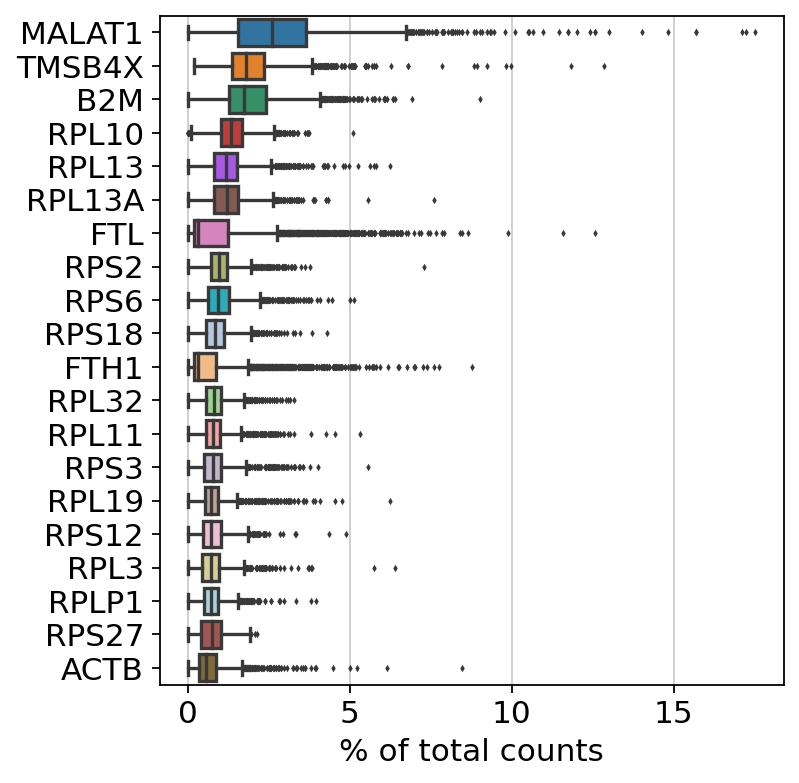

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [11]:
# basic filtering 

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [12]:
# look at mitochondrial genes for quality control 

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

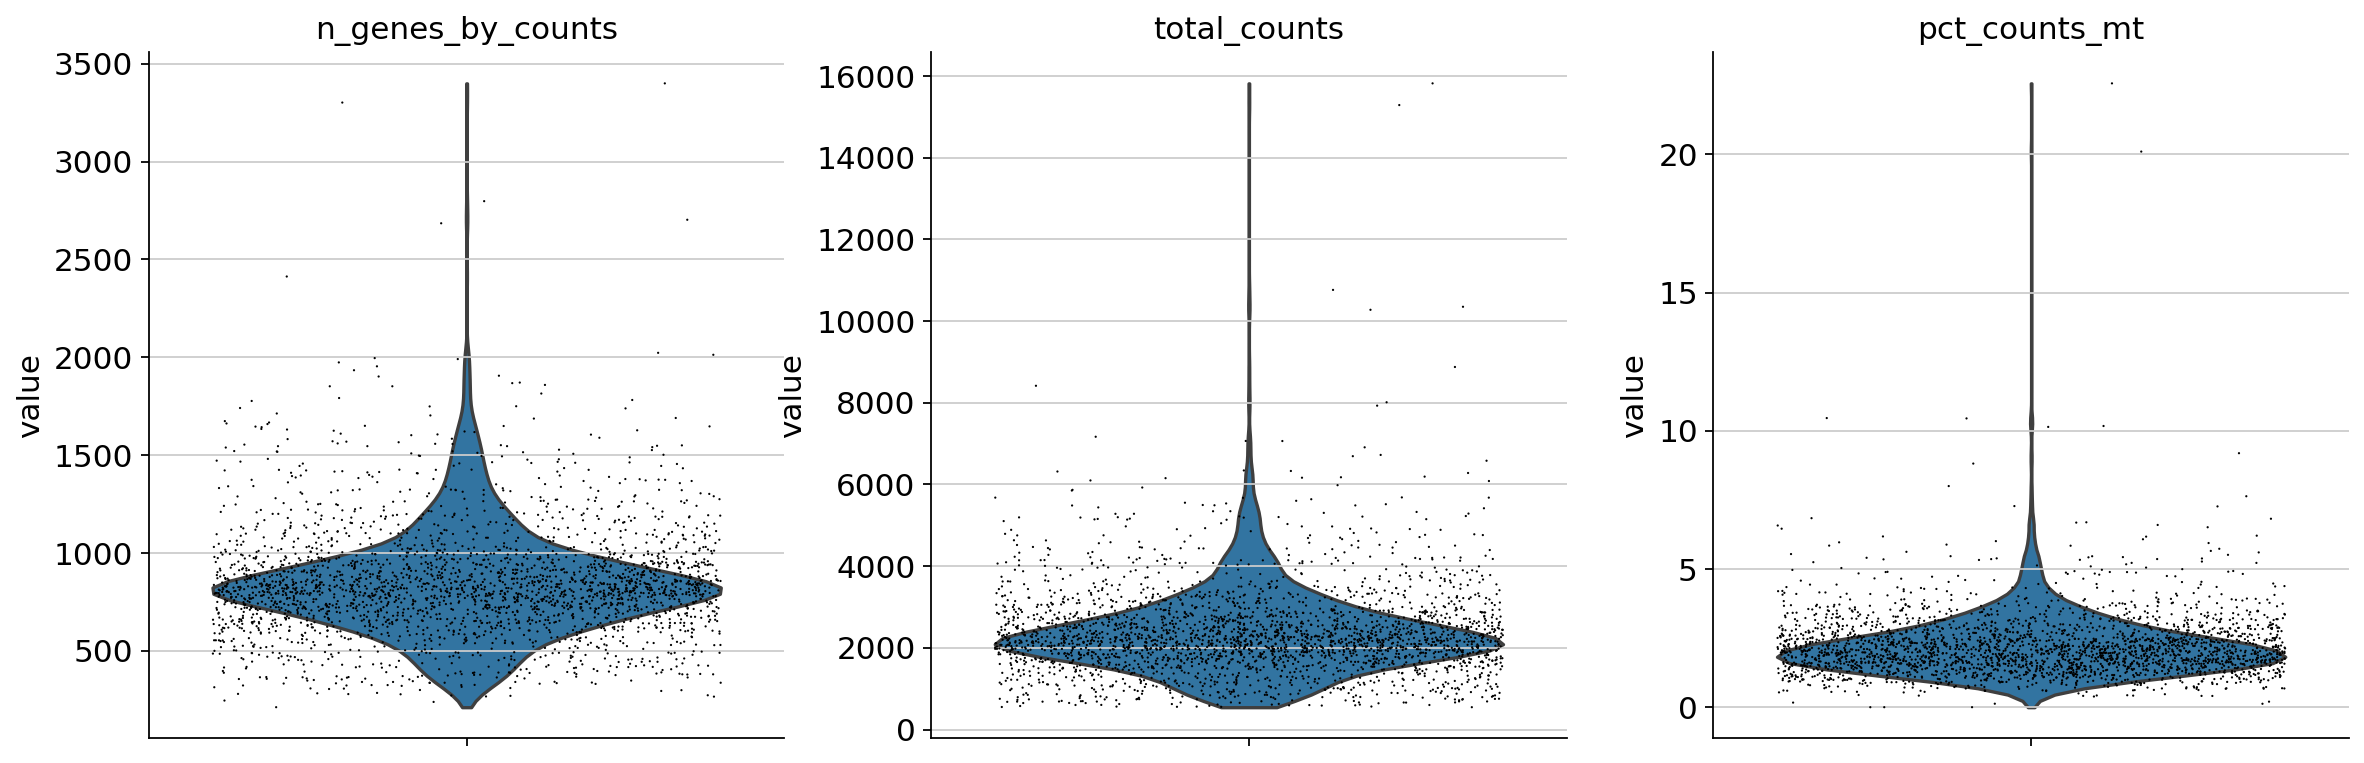

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

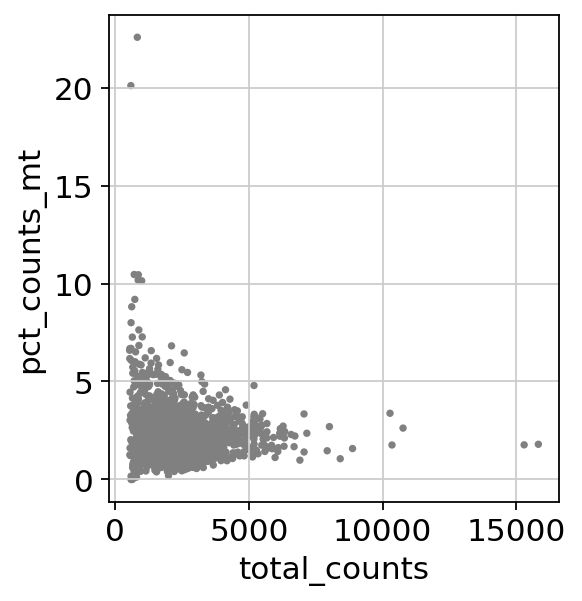

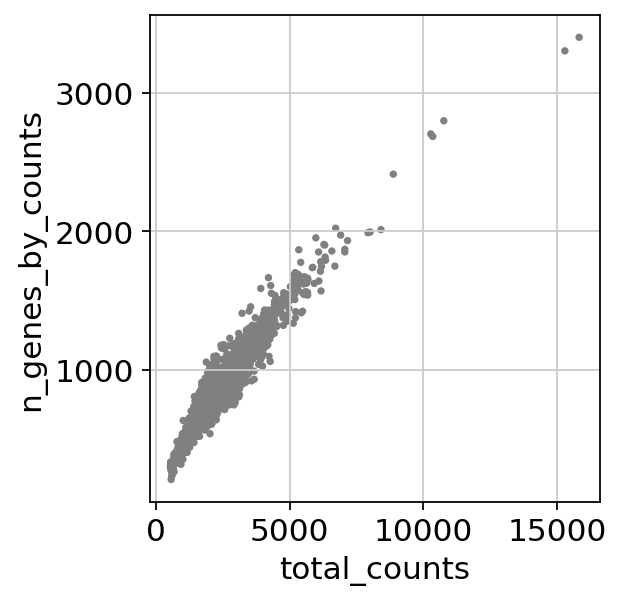

In [14]:
# remove cells with too many mitochondrial genes expressed or too many total counts 

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
# [i for i in dir(adata) if not i.startswith('_')]
# ['T',                         transpose data
#  'X',                         sparse matrix of data    
#  'chunk_X',
#  'chunked_X',
#  'concatenate',
#  'copy',
#  'file',
#  'filename',
#  'is_view',
#  'isbacked',
#  'isview',
#  'layers',
#  'n_obs',                     number of observations
#  'n_vars',                    number of variables? 
#  'obs',                       table of observations and their statistics: n_genes, n_genes_by_counts
#  'obs_keys',
#  'obs_names',
#  'obs_names_make_unique',
#  'obs_vector',
#  'obsm',
#  'obsm_keys',
#  'obsp',
#  'raw',
#  'rename_categories',
#  'shape',
#  'strings_to_categoricals',
#  'to_df',
#  'to_memory',
#  'transpose',
#  'uns',
#  'uns_keys',
#  'var',                       ??? 
#  'var_keys',
#  'var_names',
#  'var_names_make_unique',
#  'var_vector',
#  'varm',
#  'varm_keys',
#  'varp',
#  'write',
#  'write_csvs',
#  'write_h5ad',
#  'write_loom',
#  'write_zarr']

In [36]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [37]:
# total count normalize the data matrix X to 10,000 reads per cell so that counts become comparable among cells 
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/hbl/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [38]:
# log transform data
sc.pp.log1p(adata)

In [39]:
# identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


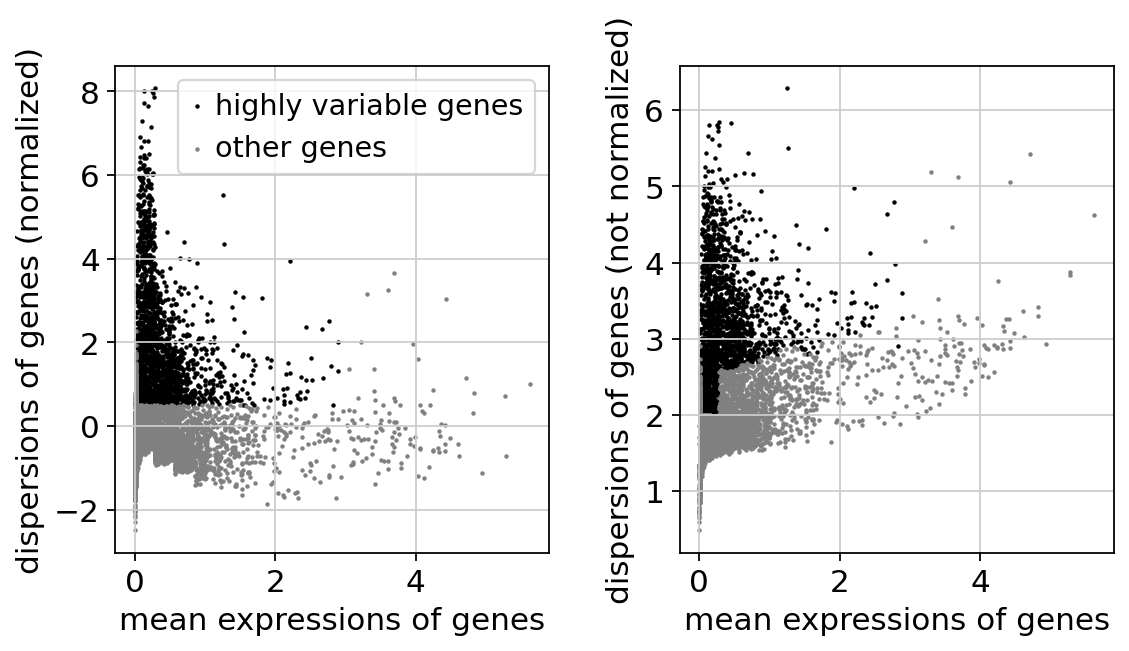

In [40]:
sc.pl.highly_variable_genes(adata)

In [41]:
adata.raw = adata

In [42]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [43]:
adata = adata[:, adata.var.highly_variable]

In [44]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes expressed 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [45]:
# scale each gene to unit variance; clip values exceeding stdev 10
sc.pp.scale(adata, max_value=10)

In [46]:
# run PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


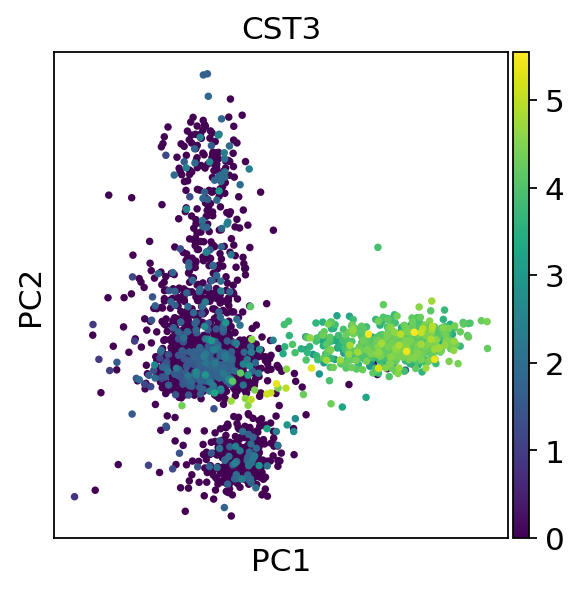

In [47]:
sc.pl.pca(adata, color='CST3')

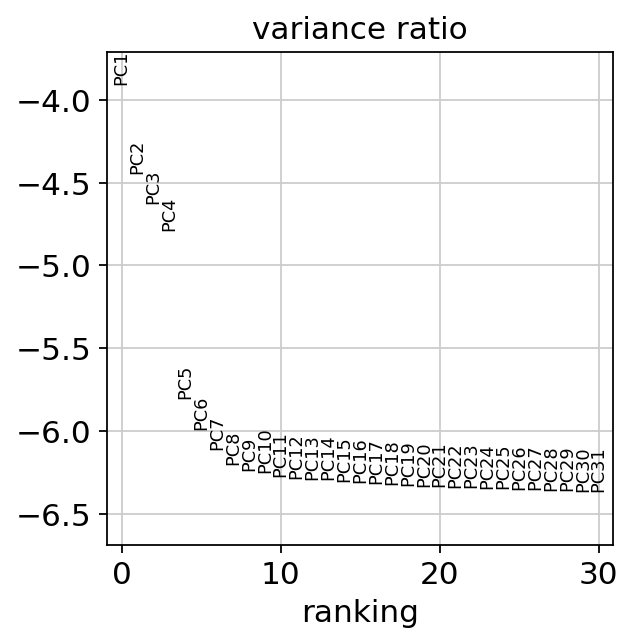

In [48]:
sc.pl.pca_variance_ratio(adata, log=True)

In [49]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [50]:
# compute neighborhood graph 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [51]:
# embed graph into two dimensions
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


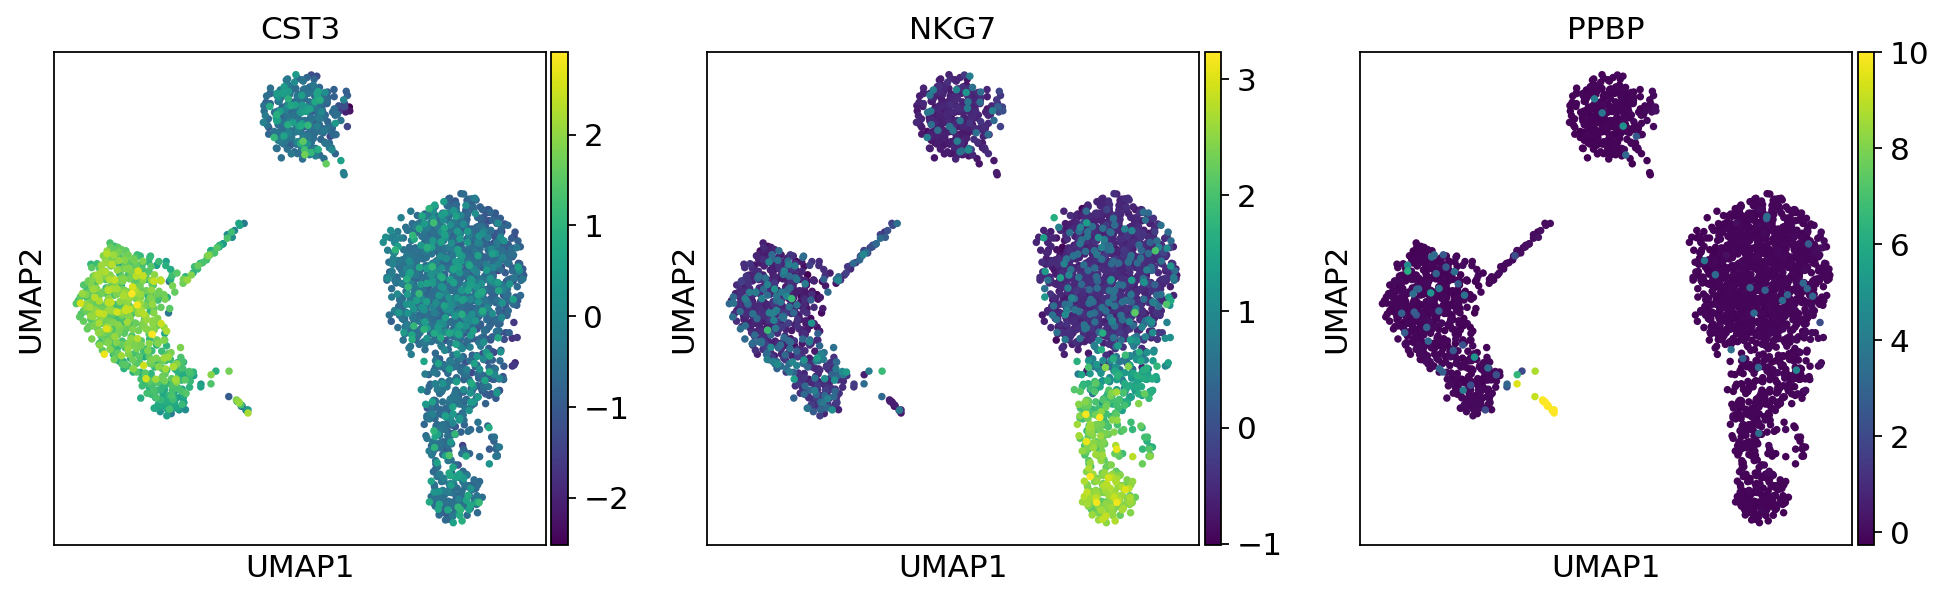

In [52]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [53]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


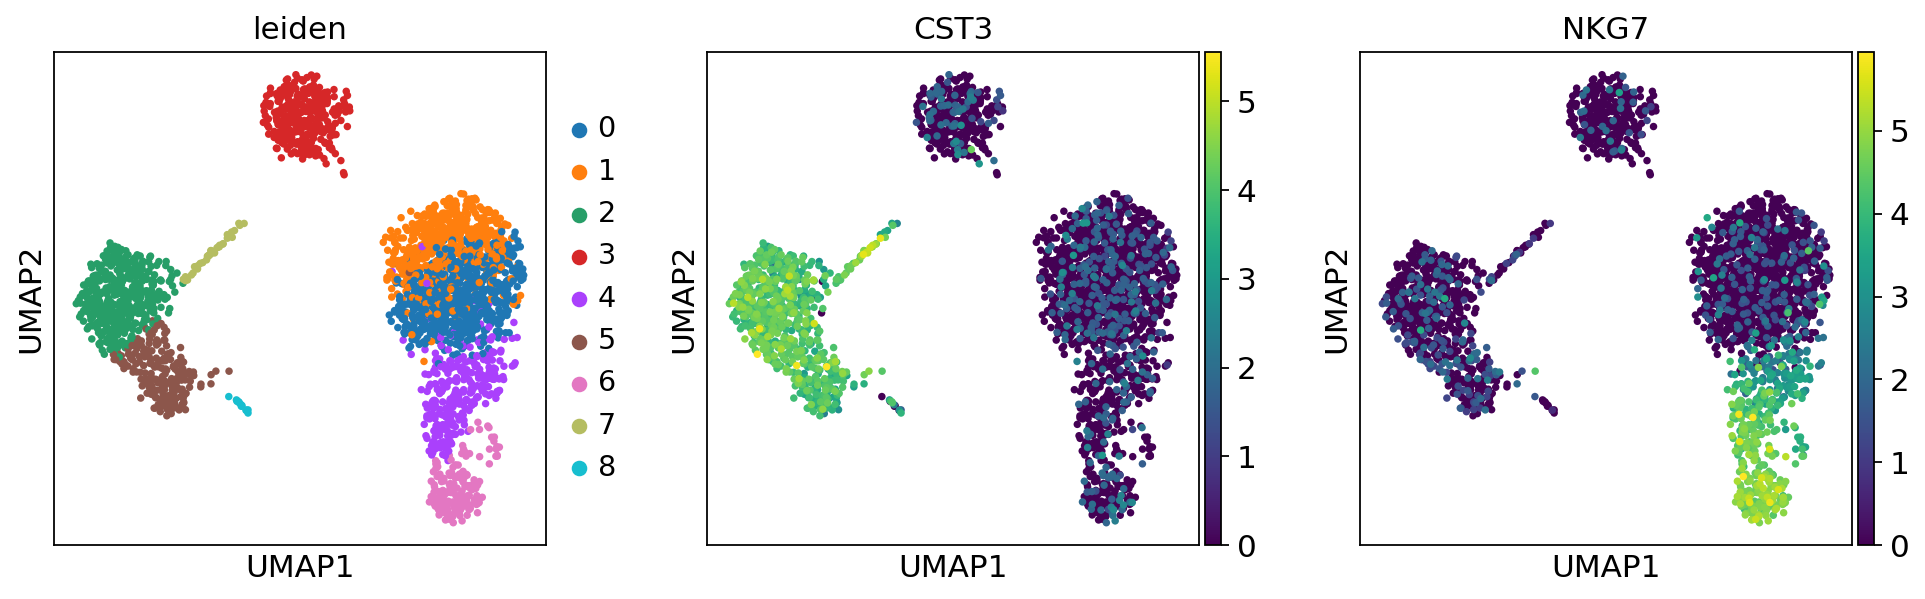

In [54]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


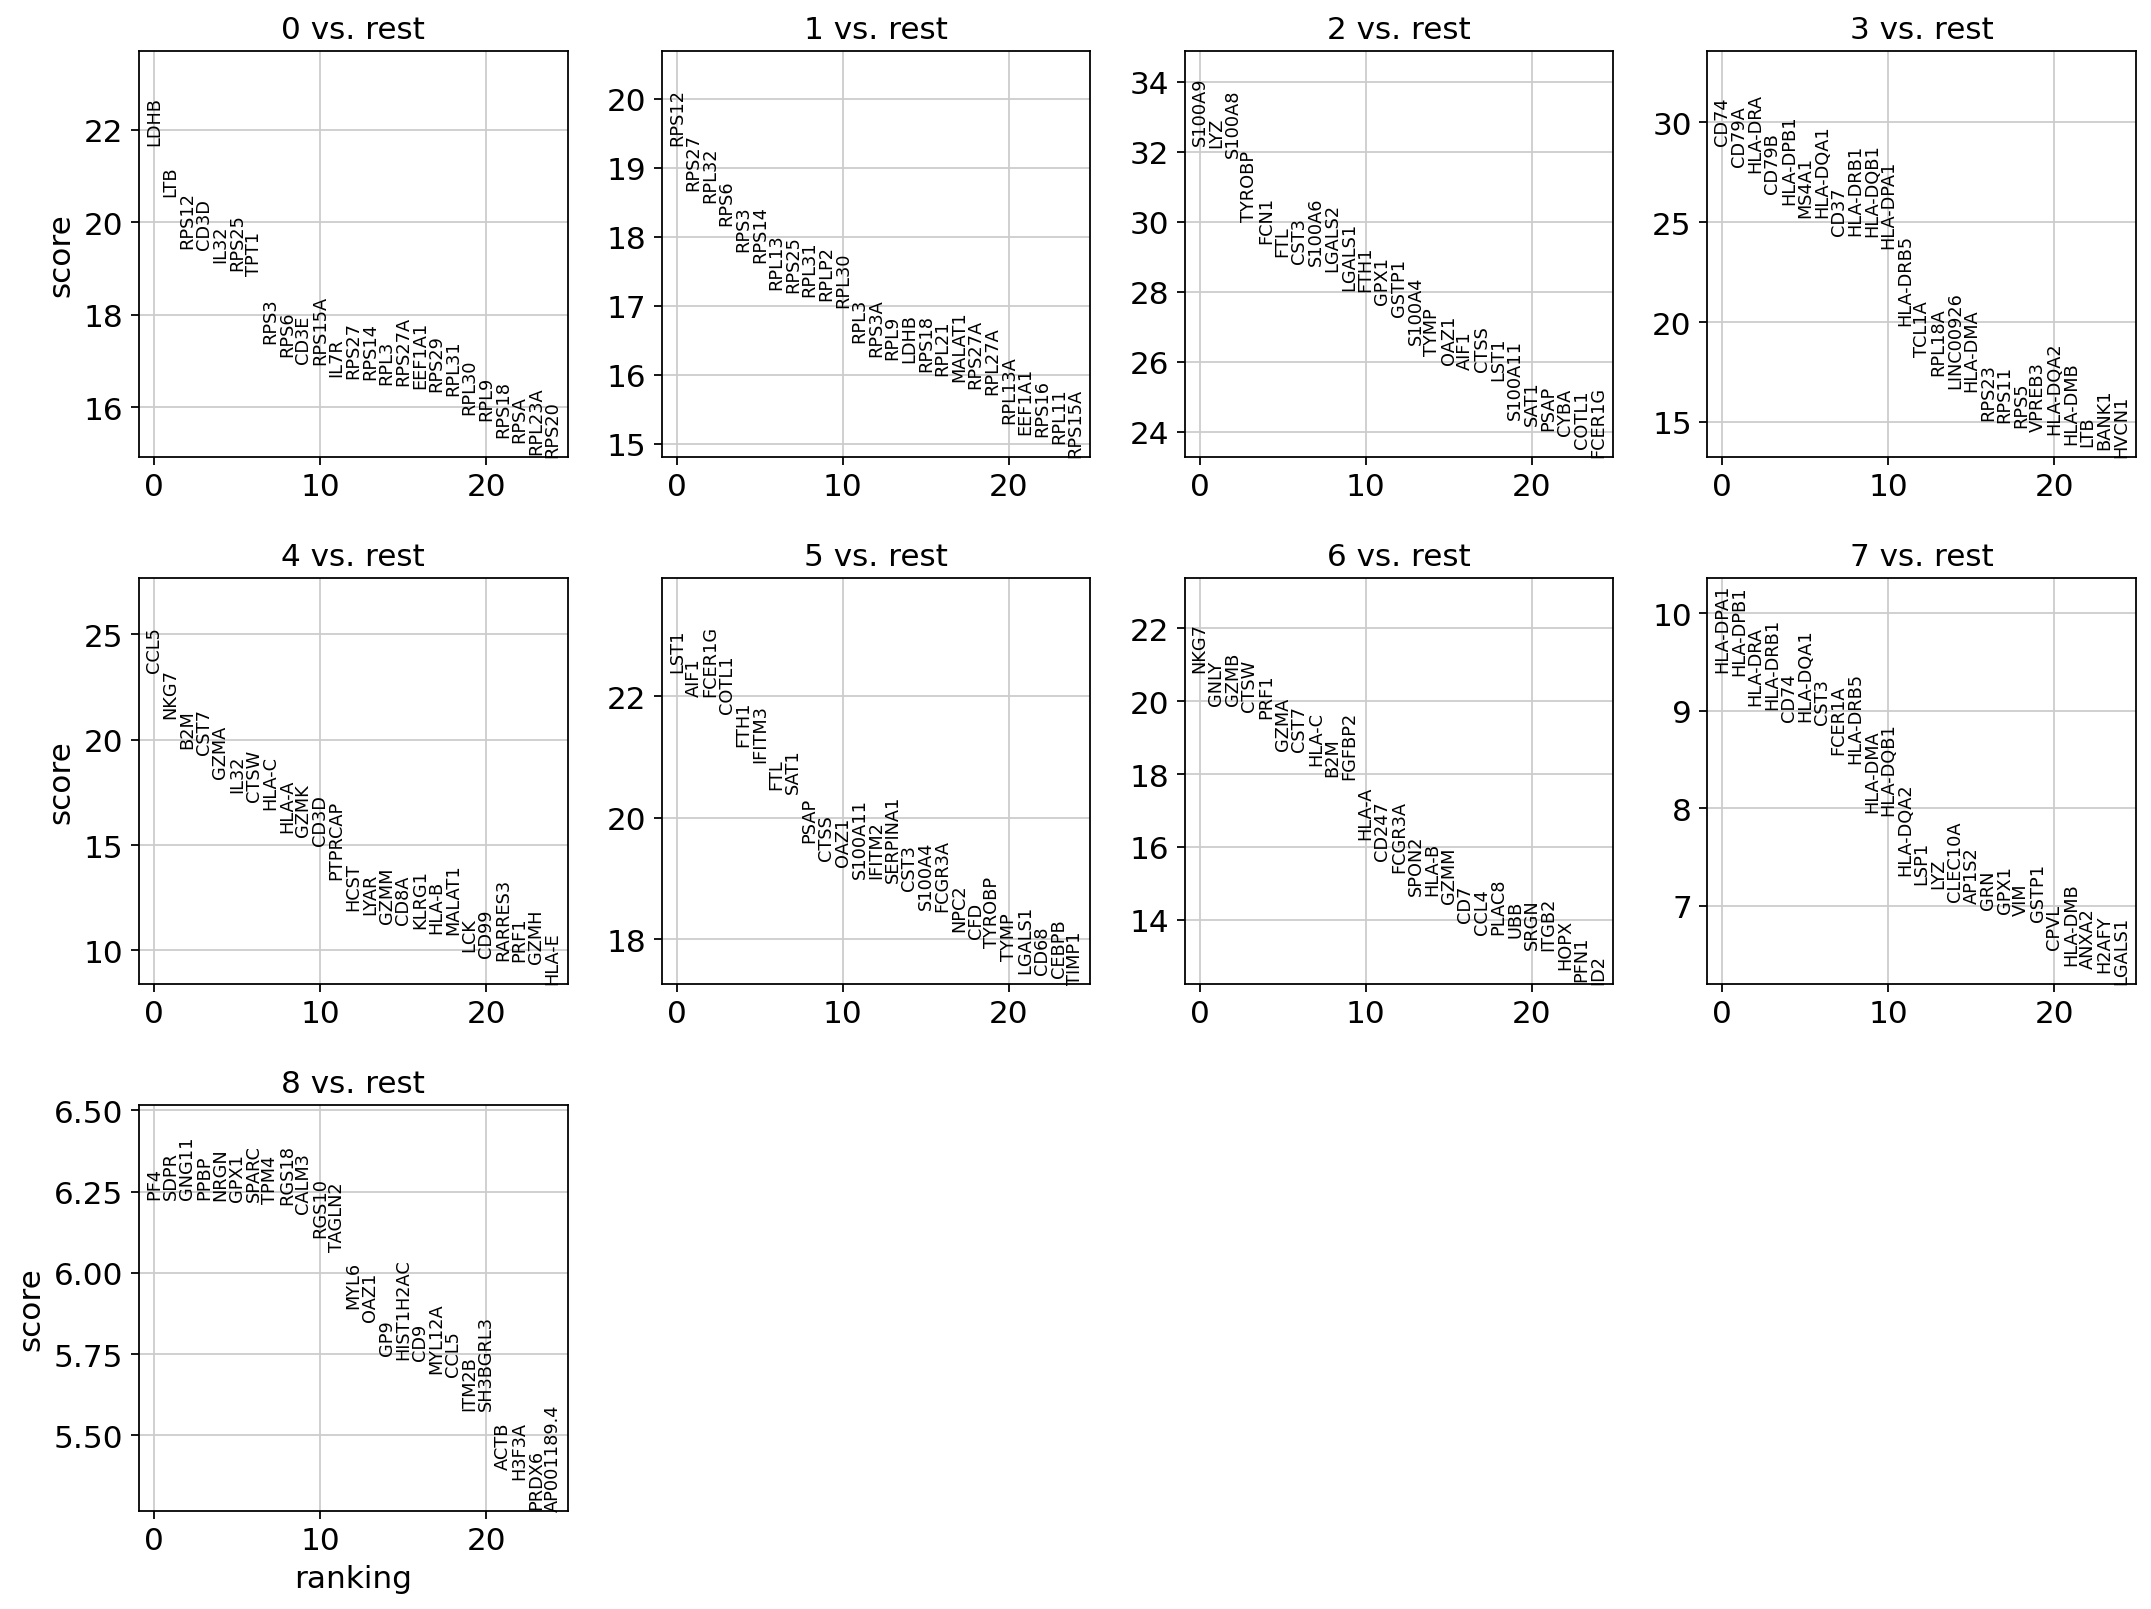

In [55]:
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [57]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
TNFRSF4,ENSG00000186827,155,False,155,0.077407,94.259259,209.0,True,0.277410,2.086050,0.665406,-3.764522e-10,0.424481
CPSF3L,ENSG00000127054,202,False,202,0.094815,92.518519,256.0,True,0.385194,4.506987,2.955005,-3.135005e-10,0.460416
ATAD3C,ENSG00000215915,9,False,9,0.009259,99.666667,25.0,True,0.038252,3.953486,4.352607,5.825179e-12,0.119465
C1orf86,ENSG00000162585,501,False,501,0.227778,81.444444,615.0,True,0.678283,2.713522,0.543183,3.841088e-10,0.685145
RER1,ENSG00000157916,608,False,608,0.298148,77.481481,805.0,True,0.814813,3.447533,1.582528,8.755421e-11,0.736050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICOSLG,ENSG00000160223,34,False,34,0.016667,98.740741,45.0,True,0.082016,2.585818,1.652185,6.580908e-12,0.217672
SUMO3,ENSG00000184900,570,False,570,0.292963,78.888889,791.0,True,0.804815,4.046776,2.431045,-4.208251e-10,0.723121
SLC19A1,ENSG00000173638,31,False,31,0.018519,98.851852,50.0,True,0.058960,3.234231,2.932458,-2.126081e-10,0.173017
S100B,ENSG00000160307,94,False,94,0.076667,96.518519,207.0,True,0.286282,3.042992,1.078783,5.952274e-10,0.399946


In [58]:
adata.obs.columns

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'leiden'],
      dtype='object')

In [65]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776,4
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596,3
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736,1
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085,5
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490,6


In [63]:
adata.var.shape, adata.obs.shape, adata.X.shape

((1838, 13), (2638, 6), (2638, 1838))

In [64]:
adata.X

array([[-0.17146961, -0.2808123 , -0.04667677, ..., -0.09826882,
        -0.20909512, -0.5312033 ],
       [-0.21458235, -0.37265328, -0.05480441, ..., -0.266844  ,
        -0.31314582, -0.5966543 ],
       [-0.3768877 , -0.29508454, -0.05752748, ..., -0.15865593,
        -0.17087644,  1.3789997 ],
       ...,
       [-0.20708963, -0.2504642 , -0.04639699, ..., -0.05114426,
        -0.16106427,  2.041497  ],
       [-0.1903285 , -0.2263338 , -0.04399936, ..., -0.00591774,
        -0.13521305, -0.48211104],
       [-0.33378935, -0.25358772, -0.05271561, ..., -0.07842438,
        -0.13032718, -0.47133783]], dtype=float32)

In [ ]:
# ['T',                         transpose data 
#  'X',                         sparse matrix of data 
#  'chunk_X',
#  'chunked_X',
#  'concatenate',
#  'copy',
#  'file',
#  'filename',
#  'is_view',
#  'isbacked',
#  'isview',
#  'layers',
#  'n_obs',                     number of observations
#  'n_vars',                    number of variables? 
#  'obs',                       table of observations and their statistics: n_genes, n_genes_by_counts
#  'obs_keys',
#  'obs_names',
#  'obs_names_make_unique',
#  'obs_vector',
#  'obsm',
#  'obsm_keys',
#  'obsp',
#  'raw',
#  'rename_categories',
#  'shape',
#  'strings_to_categoricals',
#  'to_df',
#  'to_memory',
#  'transpose',
#  'uns',
#  'uns_keys',
#  'var',                       ??? 
#  'var_keys',
#  'var_names',
#  'var_names_make_unique',
#  'var_vector',
#  'varm',
#  'varm_keys',
#  'varp',
#  'write',
#  'write_csvs',
#  'write_h5ad',
#  'write_loom',
#  'write_zarr']